In [2]:
import numpy as np
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy.optimize
import pandas as pd
from IPython.display import Audio
import csv

In [3]:
def get_envelope(t, x, d=1):
    def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
        """
        Input :
        s: 1d-array, data signal from which to extract high and low envelopes
        dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
        split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
        Output :
        lmin,lmax : high/low envelope idx of input signal s
        """

        # locals min
        lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
        # locals max
        lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1

        if split:
            # s_mid is zero if s centered around x-axis or more generally mean of signal
            s_mid = np.mean(s)
            # pre-sorting of locals min based on relative position with respect to s_mid
            lmin = lmin[s[lmin] < s_mid]
            # pre-sorting of local max based on relative position with respect to s_mid
            lmax = lmax[s[lmax] > s_mid]

        # global min of dmin-chunks of locals min
        lmin = lmin[
            [i + np.argmin(s[lmin[i : i + dmin]]) for i in range(0, len(lmin), dmin)]
        ]
        # global max of dmax-chunks of locals max
        lmax = lmax[
            [i + np.argmax(s[lmax[i : i + dmax]]) for i in range(0, len(lmax), dmax)]
        ]

        return lmin, lmax

    _, lmax = hl_envelopes_idx(x, dmax=d)
    lmax = np.interp(t, t[lmax], x[lmax])
    return lmax

def nextpow2(N):
    n = 1
    while n < N:
        n *= 2
    return n

le signal commence à 0.1125 s
niveau de silence: -47.92 dB (0.00 V)
le signal finit à 0.4125
le signal commence à 0.0965625 s
niveau de silence: -50.95 dB (0.00 V)
le signal finit à 0.3965625


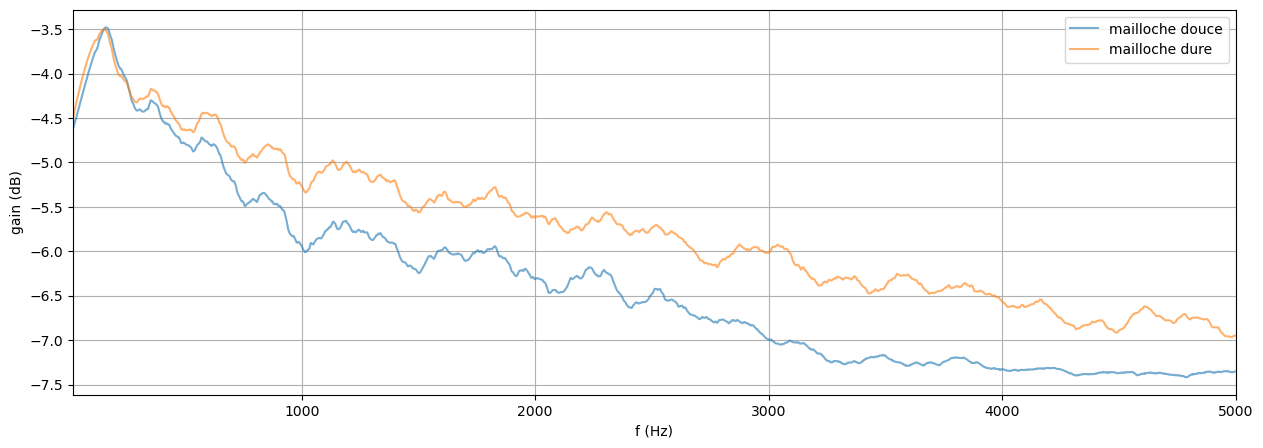

In [22]:
filenames = ["timbale-soft.wav", "timbale-hard.wav"]
sigs=[]
for filename in filenames:
    fs, sig = scipy.io.wavfile.read(filename)
    sig = sig.astype(np.float32)
    sig /= np.max(abs(sig))
    t = np.arange(len(sig)) / fs
    env = get_envelope(t, sig)

    MARGE_START_BEFORE = int(0.01 * fs)
    MARGE_START_AFTER = int(0.1 * fs)
    MARGE_SEARCH_END = int(0.2 * fs)
    MARGE_SILENCE = -0.01

    i_silence = np.argmax(abs(sig)) - MARGE_START_BEFORE
    print(f"le signal commence à {i_silence/fs} s")
    silence_level = np.max(abs(sig[:i_silence]))
    print(
        f"niveau de silence: {20*np.log10(silence_level):.2f} dB ({silence_level:.2f} V)"
    )

    t = np.arange(len(sig)) / fs
    i_start = i_silence + MARGE_START_AFTER

    i_searchend = i_start + MARGE_SEARCH_END
    i_end = i_searchend + np.argmax(env[i_searchend:] < silence_level + MARGE_SILENCE)
    print("le signal finit à", i_end / fs)
    
    sig = sig[i_silence:]
    sigs.append(sig)


l = max(len(s) for s in sigs)
for i in range(len(sigs)):
    sigs[i] = np.pad(sigs[i], (0, l-len(sigs[i])))
sigs=np.array(sigs)

N = 1*nextpow2(l)
ffts = np.fft.rfft(sigs, N, axis=1) / l
freq = np.fft.rfftfreq(N, 1/fs)
ffts= np.log10(abs(ffts))
ffts = scipy.signal.savgol_filter(ffts, 5000, polyorder=3, axis=1)

plt.figure(figsize=(15, 5))
plt.plot(freq, ffts.T, label=["mailloche douce", "mailloche dure"], alpha=0.6)
plt.xlabel("f (Hz)")
# plt.ylim(-130, -30)
plt.xlim(20,5000)
plt.grid()
plt.ylabel("gain (dB)")
plt.legend(loc="upper right")
# plt.title(ensemble)
plt.savefig(f"timbale-soft-hard.png")
plt.show()
plt.close("all")
